# TCN model

In [1]:
#!pip install deepts_forecasting

### Import libraries

In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

from deepts_forecasting.utils.data import TimeSeriesDataSet
from deepts_forecasting.utils.data.encoders import TorchNormalizer
from deepts_forecasting.datasets import AirPassengersDataset
from deepts_forecasting.models.tcn.tcn import TCNModel

D:\Anaconda3\envs\DeepTS_Forecasting\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

In [4]:
data = AirPassengersDataset().load()
data['year'] = data['Month'].dt.year
data['month'] = data['Month'].dt.month
data['group'] = '0'
data['time_idx'] = np.arange(len(data))
data['Passengers'] = data['Passengers'].astype(float)
data['month'] = data['month'].astype('str')
data.head()

,Month,Passengers,year,month,group,time_idx
0,1949-01-01,112.0,1949,1,0,0
1,1949-02-01,118.0,1949,2,0,1
2,1949-03-01,132.0,1949,3,0,2
3,1949-04-01,129.0,1949,4,0,3
4,1949-05-01,121.0,1949,5,0,4


### Split train/test sets

In [6]:
max_encoder_length = 18
max_prediction_length = 12

training_cutoff = data["time_idx"].max() - max_encoder_length - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    max_encoder_length= max_encoder_length,
    min_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_prediction_length=max_prediction_length,
    time_idx="time_idx",
    target="Passengers",
    group_ids=["group"],
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=['month'],
    time_varying_known_reals=[],
    time_varying_unknown_reals=["Passengers"],
    time_varying_unknown_categoricals=[],
    target_normalizer=TorchNormalizer(method="standard",
                                      transformation=None),
    )

training.get_parameters()
validation = TimeSeriesDataSet.from_dataset(training,
                                            data[lambda x: x.time_idx > training_cutoff])

batch_size = 16
train_dataloader = DataLoader(training, batch_size=batch_size, shuffle=False, drop_last=False)
val_dataloader = DataLoader(validation, batch_size=batch_size, shuffle=False, drop_last=False)


### Define model

In [7]:
pl.seed_everything(123)
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4,
                                    patience=60, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=300,
    gpus=0,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs")
)

model = TCNModel.from_dataset(training,
                              kernel_size=2,
                              num_filters=16,
                              num_layers=2,
                              dilation_base=2,
                              weight_norm=False,
                              target_size=1,
                              dropout=0.2,
                              )

model.summarize

Global seed set to 123
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


<bound method LightningModule.summarize of TCNModel(
  (loss): MSELoss()
  (logging_metrics): ModuleList()
  (dropout): Dropout(p=0.2, inplace=False)
  (out_linear): Linear(in_features=18, out_features=12, bias=True)
  (res_blocks): ModuleList(
    (0): ResidualBlock(
      (dropout_fn): Dropout(p=0.2, inplace=False)
      (conv1): Conv1d(1, 16, kernel_size=(2,), stride=(1,))
      (conv2): Conv1d(16, 16, kernel_size=(2,), stride=(1,))
      (conv3): Conv1d(1, 16, kernel_size=(1,), stride=(1,))
    )
    (1): ResidualBlock(
      (dropout_fn): Dropout(p=0.2, inplace=False)
      (conv1): Conv1d(16, 16, kernel_size=(2,), stride=(1,), dilation=(2,))
      (conv2): Conv1d(16, 1, kernel_size=(2,), stride=(1,), dilation=(2,))
      (conv3): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
    )
  )
)>

In [8]:
model.hparams

"dilation_base":       2
"dropout":             0.2
"input_length":        18
"kernel_size":         2
"learning_rate":       0.001
"log_interval":        -1
"log_val_interval":    None
"logging_metrics":     ModuleList()
"loss":                MSELoss()
"monotone_constaints": {}
"num_filters":         16
"num_layers":          2
"output_transformer":  TorchNormalizer()
"prediction_length":   12
"reals":               ['Passengers']
"target_size":         1
"weight_norm":         False

### Train model with early stopping

In [11]:
trainer.fit(
    model, train_dataloader=train_dataloader, val_dataloaders=val_dataloader,
)

D:\Anaconda3\envs\DeepTS_Forecasting\lib\site-packages\pytorch_lightning\trainer\trainer.py:735: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MSELoss    | 0     
1 | logging_metrics | ModuleList | 0     
2 | dropout         | Dropout    | 0     
3 | out_linear      | Linear     | 228   
4 | res_blocks      | ModuleList | 1.2 K 
-----------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
D:\Anaconda3\envs\DeepTS_Forecasting\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory lightning_logs\default\version_31\checkpoints exists and is not empty.
  rank_zero_

D:\Anaconda3\envs\DeepTS_Forecasting\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 123


## Model saved and inference

In [14]:
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = TCNModel.load_from_checkpoint(best_model_path)

# calcualte mean absolute error on validation set
actuals = torch.cat([model.transform_output(prediction=y, target_scale=x['target_scale'])
                     for x, y in iter(val_dataloader)])
predictions, target = best_model.predict(val_dataloader,return_target=True)
mae = (actuals - predictions).abs().mean()
# print('predictions shape is:', predictions.shape)
# print('actuals shape is:', actuals.shape)
print(torch.cat([actuals, predictions]))
print('MAE is:', mae)

tensor([[[417.0000],
         [391.0000],
         [419.0000],
         [461.0000],
         [472.0000],
         [535.0000],
         [622.0000],
         [606.0000],
         [508.0000],
         [461.0000],
         [390.0000],
         [432.0000]],

        [[401.7584],
         [402.7410],
         [420.2169],
         [433.6198],
         [467.2556],
         [554.4698],
         [617.7528],
         [647.0651],
         [570.2883],
         [484.3043],
         [394.6578],
         [391.2507]]], dtype=torch.float64)
MAE is: tensor(21.3422, dtype=torch.float64)


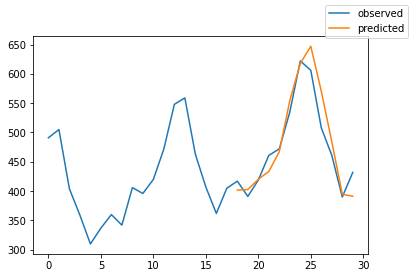

In [15]:
best_model.plot_prediction(target,predictions)
